In [18]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import joblib
import seaborn as sn

In [19]:
from hamlfeeder.data_utils import *
from hamlfeeder.alarm_common import request_live_data
from hamlfeeder.convert_to_tf_litle import convert_model

## Deep Learning Model for manage HomeAssistant Alarm based on anothers sensor states

In [20]:
update_database()
df = get_normalized(get_dataframe(get_uuids()))
X = df.loc[:, df.columns != 'target']
y = df.target

Actualizando copia local de la base de datos...


In [21]:
df.tail(10)

,d_sin,d_cos,hr_sin,hr_cos,min_cos,min_sin,mvn,mvr,ls,tv,sun,sl,sps,target
370,0.781831,0.623490,-8.660254e-01,5.000000e-01,-0.809017,0.587785,1,1,1,1,0,-0.318994,0.629127,0
371,-0.433884,-0.900969,5.000000e-01,-8.660254e-01,-0.207912,0.978148,1,0,0,1,1,1.229661,-1.195325,0
372,-0.433884,-0.900969,-9.659258e-01,2.588190e-01,0.743145,0.669131,1,1,1,1,0,-0.531606,1.099346,0
373,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,-0.104528,0.994522,0,0,0,0,0,-1.014576,0.857930,1
374,-0.433884,-0.900969,7.071068e-01,-7.071068e-01,-0.994522,-0.104528,0,1,0,0,1,1.108919,-0.295266,0
375,0.000000,1.000000,-9.659258e-01,-2.588190e-01,0.866025,0.500000,0,0,0,0,1,1.030173,-1.419196,1
376,-0.781831,0.623490,-9.659258e-01,-2.588190e-01,0.951057,0.309017,1,1,0,0,1,0.224348,0.432592,0
377,0.433884,-0.900969,-5.000000e-01,8.660254e-01,0.978148,0.207912,1,1,1,1,0,-0.481734,0.599861,0
378,-0.974928,-0.222521,1.224647e-16,-1.000000e+00,0.913545,-0.406737,1,1,0,1,1,0.938304,-1.610049,0
379,-0.781831,0.623490,-1.000000e+00,-1.836970e-16,-0.809017,-0.587785,1,1,1,1,0,-0.481734,0.432592,0


### Features in order: 
* Day of week sine
* Day of week cosine
* hour of day sine
* hour of day cosine
* minute of hour cosine
* minute of hour sine
* Mobile #1 presence
* Mobile #2 presence
* Living Room light status
* TV of living room status
* Sun (Day/night)
* Light sensor at living room
* Seconds since outdoor last opened
* Alarm desired status (target)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print("Total number of samples: {} and features: {}".format(X.shape[0], X.shape[1]))
print("Train samples: {} Test samples: {}".format(X_train.shape[0], X_test.shape[0]))

Total number of samples: 380 and features: 13
Train samples: 254 Test samples: 126


In [23]:
print(pd.DataFrame({'Percentage': df.groupby(('target')).size() / len(df)}))

        Percentage
target            
0         0.560526
1         0.439474


In [24]:
print("Train label dist: 1[{}] vs 0[{}]".format(sum(y_train), len(y_train)-sum(y_train)))

Train label dist: 1[112] vs 0[142]


In [25]:
def create_model():
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(60, activation='relu', kernel_initializer='normal', input_dim=len(X_train.columns)))#Second  Hidden Layer
    #classifier.add(Dense(10, activation='relu', kernel_initializer='normal'))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    return classifier

In [26]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=60, batch_size=10, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Results: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

Results: 88.60% (+/- 4.51%)


In [27]:
model = create_model()
model.fit(X_train, y_train, batch_size=10, epochs=60, verbose=0)
eval_model=model.evaluate(X_test, y_test)
print(eval_model[1])

126/126 [==============================] - 0s 320us/sample - loss: 0.2202 - accuracy: 0.9206
0.9206349


In [28]:
model.save('/home/roberto/devel/python/hamlfeeder/keras_bincross_model.h5')

In [29]:
# convertimos el model a tf lite para la raspbi
convert_model(model)

ok


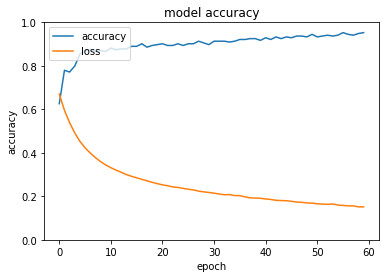

In [30]:
history_dict = model.history.history
plt.plot(model.history.history['accuracy']) # en versiones nuevas es accuracy la key
plt.plot(model.history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

[[64  7]
 [ 3 52]]


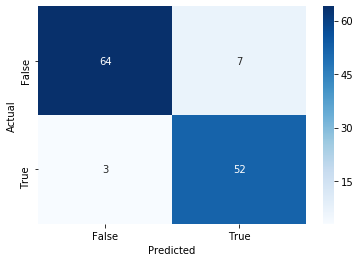

In [31]:
# Confusion matrix con los datos de test
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_pred), index= np.unique(y_pred))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
#plt.figure(figsize = (10,7))
#sn.set(font_scale=1.4)
#sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="d")
print(cm)



In [32]:
# PROBAMOS EN DIRECTO
df2 = request_live_data()
#df2['target'] = 0
df2

,d_sin,d_cos,hr_sin,hr_cos,min_cos,min_sin,mvn,mvr,ls,tv,sun,sl,sps
0,0.781831,0.62349,1.224647e-16,-1.0,0.913545,-0.406737,0,0,0,0,1,1.229661,-1.168525


In [33]:
# PREDECIMOS
last_y_pred = model.predict(df2)
last_y_pred = (last_y_pred>0.5)
print(last_y_pred)
print(round(model.predict_proba(df2)[0][0],2))

[[ True]]
0.87


In [34]:
corr = df[[ 'd_sin','d_cos', 'hr_sin', 'hr_cos', 'min_cos', 'min_sin',
        'mvn', 'mvr', 'ls', 'tv', 'sun', 'sl', 'sps', 'target']].corr()
corr.style.background_gradient(cmap='coolwarm')

,d_sin,d_cos,hr_sin,hr_cos,min_cos,min_sin,mvn,mvr,ls,tv,sun,sl,sps,target
d_sin,1,0.055521,0.154037,-0.0216091,-0.0291612,-0.0371458,-0.0744786,-0.0602005,-0.0609747,-0.121356,-0.0562158,-0.0948514,0.0550376,0.0310257
d_cos,0.055521,1,0.12424,0.0102592,0.0338142,-0.0131055,-0.13603,-0.0373027,0.0189526,-0.0274367,-0.00783767,-0.0604108,-0.118027,0.142398
hr_sin,0.154037,0.12424,1,-0.218121,-0.0658728,-0.0677389,-0.391339,-0.24794,-0.284192,-0.241684,0.0546667,-0.0880082,-0.481733,0.321376
hr_cos,-0.0216091,0.0102592,-0.218121,1,0.04181,0.0291901,0.292395,0.264871,0.681584,0.212744,-0.856335,-0.676972,0.422603,0.257651
min_cos,-0.0291612,0.0338142,-0.0658728,0.04181,1,-0.00836771,-0.0203572,0.0427304,0.0263637,-0.00823658,-0.0372649,-0.0675302,0.0295967,-0.0027619
min_sin,-0.0371458,-0.0131055,-0.0677389,0.0291901,-0.00836771,1,0.00916379,-0.0139805,0.0378624,0.0911344,-0.0180479,0.0242078,-0.0110819,-0.0214823
mvn,-0.0744786,-0.13603,-0.391339,0.292395,-0.0203572,0.00916379,1,0.321734,0.480031,0.581437,-0.176674,0.0440187,0.359546,-0.441114
mvr,-0.0602005,-0.0373027,-0.24794,0.264871,0.0427304,-0.0139805,0.321734,1,0.307617,0.376641,-0.157624,-0.143165,0.444755,-0.362306
ls,-0.0609747,0.0189526,-0.284192,0.681584,0.0263637,0.0378624,0.480031,0.307617,1,0.427734,-0.589507,-0.276631,0.367423,-0.0145143
tv,-0.121356,-0.0274367,-0.241684,0.212744,-0.00823658,0.0911344,0.581437,0.376641,0.427734,1,-0.0651809,0.0721157,0.352145,-0.356118
